# task 3.1

Consider the same situation of tasks 1.1 and 1.2 in assignment 1, but modify the $u_t$'s so to be 10 uniformly spaced values in $[-1, 1]$, and set $\alpha = 0$ so that we have Laplacian noises (more precisely, with scale $\beta = 1$). Use as the "true model" a quartic.

In [10]:
# importing the right packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [11]:
# define the function that creates an arbitrary polynomial
# that we will use also to create the scalar quadratic
# 'true model'
#
# note that this function uses both 'lambda functions' and
# the 'enumerate' function -- two features of python
def arbitrary_poly(theta):
    noiseless_y = lambda x: sum([p*(x**i) for i, p in enumerate(theta)])
    return noiseless_y

In [12]:
# Non-random generation between code executions.
# Comment out if you want to repeat the same experiment over and over again
# np.random.seed(123)

In [13]:
# for readability
min_u = -1
max_u = 1
N     = 10 # number of samples

# create the u_t's
u = np.linspace(min_u, max_u, N)

In [14]:
# define the function for the mixture distribution
def noise(alpha, beta, sigma, N):
    if np.random.uniform() < alpha:
        noise = np.random.normal(0, sigma, N)
    else:
        noise = np.random.laplace(0, beta, N)
    return noise

# task 3.2

Code again both the LS and ML estimators, but this time add the possibility of testing 10 different model structures, i.e., polynomials from order 0 to order 9.

In [15]:
# define the function solving the LS problem asked in the assignment
def LS_solver( u, y, model_order ):

    # create the features matrix
    U = u[:, np.newaxis] ** np.arange( model_order )

    # compute the LS estimate by directly solving the normal equations
    theta_hat = np.linalg.solve(U.T @ U, U.T @ y)

    return theta_hat

In [16]:
# define the Laplacian log likelihood function
#
# note that here "x" stands for "theta"
def laplace_log_likelihood(x, u, y):
    
    # this parameter is fixed by the problem formulation 
    scale = 1
    
    # initialization of the returned value
    negative_log_likelihood = 0
    
    # cycle on all the samples
    for j, current_u in enumerate(u):
    
        # for readability
        modelled_y = sum([theta_i * (current_u ** i) for i, theta_i in enumerate(x)])
        measured_y = y[j]
    
        # compute the actual likelihood per sample
        negative_log_likelihood -= (
              np.log(
                        (1.0/(2.0 * scale))
                      * np.exp( -np.abs(modelled_y - measured_y) / scale )
                    ) )

    return negative_log_likelihood

In [17]:
# define the function solving the ML problem asked in the assignment
def ML_solver( u, y, model_order ):

    # compute the ML estimate by directly minimizing the log likelihood
    opt_res = optimize.minimize(
                fun     = laplace_log_likelihood,
                x0      = np.zeros( model_order ),
                args    = (u, y),
                options = {'disp': False} )

    # save the result in a more readable format
    theta_hat = opt_res.x
    
    # debug
#    print('estimated parameters = ', theta_hat)
    
    return theta_hat

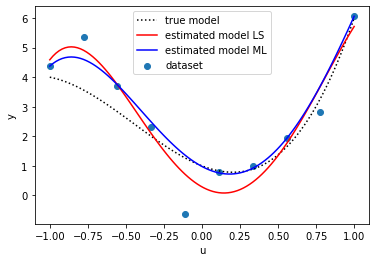

In [21]:
# DEBUG
# check that everything works

# set the parameters
theta_true = [1, -2, 4, 3]
alpha = 0
beta  = 1
sigma = 1
guessed_model_order = 5

# create the noisy dataset
noiseless_y = arbitrary_poly(theta_true) # use the lambda function
y = noiseless_y( u ) + noise( alpha, beta, sigma, len(u) )

# solve the LS and ML problems
theta_hat_LS = LS_solver( u, y, guessed_model_order )
theta_hat_ML = ML_solver( u, y, guessed_model_order )

# compute the estimated models
modeled_y_LS = arbitrary_poly(theta_hat_LS) # use the lambda function
modeled_y_ML = arbitrary_poly(theta_hat_ML) # use the lambda function

# plot the true model against the measurements and the estimated model
x = np.linspace(start = min_u, stop = max_u, num = 100)
plt.figure()
plt.scatter(u, y,                  label = 'dataset')
plt.plot(x, noiseless_y(x),  'k:', label = 'true model')
plt.plot(x, modeled_y_LS(x), 'r',  label = 'estimated model LS')
plt.plot(x, modeled_y_ML(x), 'b',  label = 'estimated model ML')
plt.xlabel('u')
plt.ylabel('y')
plt.legend();

# task 3.3

Code only the "model order selection / parameters estimation" paradigm by considering the first half of the dataset as a training set, and the second as a test set. As "performance index" consider all the various indexes for regression problems we saw in class.

In [22]:
# define the dataset
training_u   = u[:5]
training_y   = y[:5]
testing_u    = u[6:]
testing_y    = y[6:]

In [25]:
# define the performance indexes for this specific assignment
def performance_indexes( measured_y, estimated_y ):
    
    RSS = sum( ( measured_y - estimated_y ) ** 2 )
    FVU = RSS / ( len(measured_y) * np.var( measured_y ) )
    Rsquared = 1 - FVU
    fit = 100 * ( 1 - FVU )
    MAD = sum( abs( measured_y - estimated_y ) )
    
    return [ RSS, FVU, Rsquared, fit, MAD ]

# task 3.4

Make two plots: one showing the dependency of the various performance indexes computed on the training set on the model order, and one showing the same dependency, but on the test set.

In [30]:
# for readability
max_model_order = 11

# storage allocation: 0 = training, 1 = testing
RSS_LS      = np.zeros( (2, max_model_order) )
FVU_LS      = np.zeros( (2, max_model_order) )
Rsquared_LS = np.zeros( (2, max_model_order) )
fit_LS      = np.zeros( (2, max_model_order) )
MAD_LS      = np.zeros( (2, max_model_order) )
#
RSS_ML      = np.zeros( (2, max_model_order) )
FVU_ML      = np.zeros( (2, max_model_order) )
Rsquared_ML = np.zeros( (2, max_model_order) )
fit_ML      = np.zeros( (2, max_model_order) )
MAD_ML      = np.zeros( (2, max_model_order) )

# do the training and testing for each model order
for m in range(1, max_model_order):

    # 1) train on the training set
    theta_hat_LS = LS_solver( training_u, training_y, m )
    theta_hat_ML = ML_solver( training_u, training_y, m )

    # 2) create the models
    modeled_y_LS = arbitrary_poly(theta_hat_LS) # use the lambda function
    modeled_y_ML = arbitrary_poly(theta_hat_ML) # use the lambda function

    # 3) predict both the training and the test sets
    predicted_training_y_LS = modeled_y_LS(training_u)
    predicted_training_y_ML = modeled_y_ML(training_u)
    #
    predicted_testing_y_LS = modeled_y_LS(testing_u)
    predicted_testing_y_ML = modeled_y_ML(testing_u)

    # 4) compute the performance indexes on the predictive capabilities on the training set
    [ RSS_LS[0][m], FVU_LS[0][m], Rsquared_LS[0][m], fit_LS[0][m], MAD_LS[0][m] ] = (
        performance_indexes( training_y, predicted_training_y_LS ) )
    [ RSS_ML[0][m], FVU_ML[0][m], Rsquared_ML[0][m], fit_ML[0][m], MAD_ML[0][m] ] = (
        performance_indexes( training_y, predicted_training_y_ML ) )
    
    # 5) compute the performance indexes on the predictive capabilities on the test set
    [ RSS_LS[1][m], FVU_LS[1][m], Rsquared_LS[1][m], fit_LS[1][m], MAD_LS[1][m] ] = (
        performance_indexes( testing_y, predicted_testing_y_LS ) )
    [ RSS_ML[1][m], FVU_ML[1][m], Rsquared_ML[1][m], fit_ML[1][m], MAD_ML[1][m] ] = (
        performance_indexes( testing_y, predicted_testing_y_ML ) )

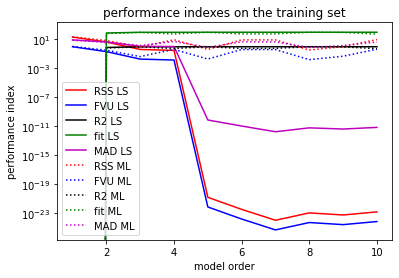

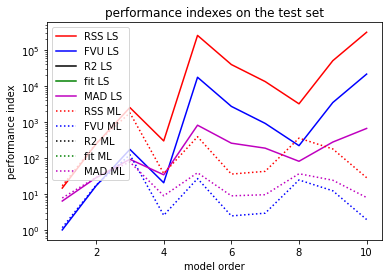

In [40]:
# plot the results
for i in range(0,2):

    plt.figure(i)
    plt.plot(range(1, max_model_order), RSS_LS[i][1:max_model_order],      'r', label = 'RSS LS')
    plt.plot(range(1, max_model_order), FVU_LS[i][1:max_model_order],      'b', label = 'FVU LS')
    plt.plot(range(1, max_model_order), Rsquared_LS[i][1:max_model_order], 'k', label = 'R2 LS')
    plt.plot(range(1, max_model_order), fit_LS[i][1:max_model_order],      'g', label = 'fit LS')
    plt.plot(range(1, max_model_order), MAD_LS[i][1:max_model_order],      'm', label = 'MAD LS')
    #
    plt.plot(range(1, max_model_order), RSS_ML[i][1:max_model_order],      'r:', label = 'RSS ML')
    plt.plot(range(1, max_model_order), FVU_ML[i][1:max_model_order],      'b:', label = 'FVU ML')
    plt.plot(range(1, max_model_order), Rsquared_ML[i][1:max_model_order], 'k:', label = 'R2 ML')
    plt.plot(range(1, max_model_order), fit_ML[i][1:max_model_order],      'g:', label = 'fit ML')
    plt.plot(range(1, max_model_order), MAD_ML[i][1:max_model_order],      'm:', label = 'MAD ML')
    #
    plt.xlabel('model order')
    plt.ylabel('performance index')
    plt.yscale('log')
    plt.legend();
    if i == 0:
        plt.title('performance indexes on the training set');
    else:
        plt.title('performance indexes on the test set');


# task 3.5

Interpret the two plots in terms of overfitting / underfitting, and in terms of bias vs variance tradeoff.

The plot on the training set shows that typically all the performance indexes, independently of the type of estimator, tend to reconstruct better the training set when the model order is higher. This is as expected, since during training we are trying to interpolate as well as possible the training set, and using a higher order polynomial gives more capabilities in doing this interpolation.

The problem though is that in this way, higher order models fit 'too much' the training set (a.k.a. 'overfit') and then they generalize poorly on the test set. Indeed the plot on the test set shows that the performance indexes tend to decay with a higher order.

Note that in this case we have very little data in the dataset, so it is a bit difficult to see 'underfitting' phenomena. It is though possible to see the phenomenon for which the variance of the estimator grows significantly with the model order complexity.
